In [33]:
import random
import itertools

import sklearn.datasets
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from Ball_Tree import Ball_Tree

In [2]:
np.random.seed(42)

In [34]:
#This is a really easy case
X, y= sklearn.datasets.make_blobs(n_samples=1000, cluster_std=.3, centers=[(2,2),(4,2)])
scaled_X = MinMaxScaler().fit_transform(X)

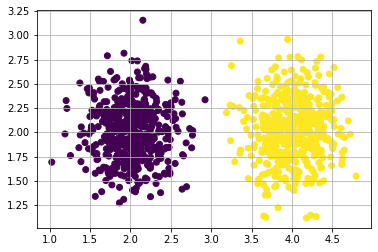

In [4]:
plt.grid()
plt.scatter(X[:,0],X[:,1],c=y)

In [5]:
tree = Ball_Tree(X, 20)

In [56]:
class Clusterer():
    
    def __init__(self, gridsize=20, n_elements=1, eps=.1):
        self.gridsize = gridsize
        self.eps = eps
        self.n_elements = n_elements
        
    def fit(self, X):
        tree = Ball_Tree(X, self.n_elements)
        self.grid = self.initialize_grid(X, tree) # self is temp for debug
        
    def initialize_grid(self, X, tree):
        n_dim = X.shape[1]
        min_coord = X.min() - self.eps*1.0001 #the 1.001 is a fudge factor. Want points at edge to have 0 density
        max_coord = X.max() + self.eps*1.0001
        print(max_coord)
        width = max_coord - min_coord
        offset = width / (self.gridsize - 1) # this is necessary because you want to have points on both ends
        shape = (self.gridsize,)*n_dim
        grid = np.empty(shape)
        for grid_i in itertools.product(range(self.gridsize),repeat=n_dim):
            coords = np.array([offset*i+min_coord for i in grid_i])
            #coords is a coordinate pair in n_dim space
            grid[grid_i] = tree.calc_local_density(coords, self.eps)
            plt.scatter(coords[0], coords[1])
            print(tree.calc_local_density(coords, self.eps)) #LEFT OF HERE
        return grid

In [ ]:
clusterer = Clusterer(eps=.1)
clusterer.fit(scaled_X)


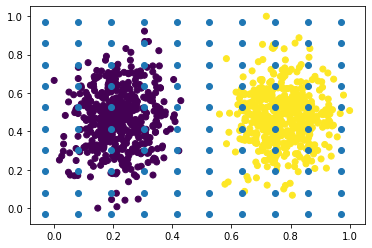

In [74]:
plt.scatter(scaled_X[:,0],scaled_X[:,1],c=y)
grid = np.array([[x[0]*(1/9)-.03,x[1]*(1/9)-.03] for x in itertools.product(range(10),repeat=2)])
plt.scatter(grid[:,0],grid[:,1], c = clusterer.grid)


In [15]:
clusterer.grid[clusterer.grid > 0.1]

array([ 15.,  46.,  22., 410., 283.,  33., 440.,  91.,   1.,  50.,   1.,
         1.])

In [9]:
def make_grid(X, ):
    X
        

In [10]:
make_grid(X)

3.7656832061258325

## Debugging Ball Tree

In [38]:
def naive_density(data_pt, X, epsilon):
    return np.nonzero((distance.cdist(data_pt.reshape(1,-1), X) < epsilon)[0])[0].shape[0]

In [7]:
def compare(data_pt, epsilon):
    print(f'naive:{naive_density(data_pt, X, epsilon)}\tball:{tree.calc_local_density(data_pt, epsilon)}')
def compare_bool(data_pt, epsilon):
    n_d = naive_density(data_pt, X, epsilon)
    b_d = tree.calc_local_density(data_pt,epsilon)
    if n_d != b_d:
        print(f'{n_d}!={b_d}')
        print(type(n_d), type(b_d))

In [8]:
a=np.array([0,1])
b = np.array([0,0])
for x in X:
    compare_bool(x, random.random() * 2)


In [ ]:
tree.root.data_pt

In [ ]:
tree.root.radius

In [ ]:
distance.euclidean(a,tree.root.data_pt) + tree.root.radius

In [ ]:
def plot_node(node, color):
    plt.scatter(X[:,0],X[:,1],c=y)
    plt.scatter(node.data_pt[0], node.data_pt[1], c=color)
    plt.axis("equal")
    plt.grid()
    plt.show()

In [ ]:

left = tree.root
right = tree.root
while left:
    print(left.data_pt, X[left.data_pt_i], left.n_elements, left.radius)
    plot_node(left, 'r')
    plot_node(right, 'b')
    left = left.left
    right = right.right

## scratch

In [ ]:
arr = np.array([[1,2,3],[4,5,6]])

In [ ]:
(arr[0] <=2).sum()

In [ ]:
type((distance.cdist(np.array([0,0,0]).reshape(1,-1), arr)[0] <= 2).sum())